# Running quantum circuits on QPU devices

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In this tutorial we show how to run circuits on QPU devices. We can run our circuit on both the superconducting machine from Rigetti and the ion-trap machine provided by IonQ. As shown below, one can seamlessly swap between different devices without any modifications to the circuit definition, by just re-defining the device object. We also show how to recover results using the unique ARN associated with every quantum task. This tool is useful in order to deal with potential delays if your quantum task sits in the queue for some time waiting for execution. 

In [2]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, observables
from braket.device_schema import DeviceActionType
from braket.devices import Devices, LocalSimulator
from braket.parametric import FreeParameter

### Supported gate sets by different devices

First, let us check out the gate set currently supported by our SDK. As with on-demand simulators, you can instantiate a QPU by passing its ARN into `AwsDevice`. Note that the QPU devices only support a subset of these gates.

https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html


In [3]:
# print all (the usual suspects) available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:\n', gate_set)
print('\n') 

#해당 디바이스에서 지원하는 OpenQASM 게이트 목록을 가져와 출력
# the Rigetti device
#rigetti = AwsDevice(Devices.Rigetti.Ankaa2)
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2")
supported_gates = rigetti.properties.action[DeviceActionType.OPENQASM].supportedOperations
# print the supported gate set
print('Gate set supported by the Rigetti device:\n', supported_gates)
print('\n') 

#해당 디바이스에서 지원하는 OpenQASM 게이트 목록을 가져와 출력
# the IonQ device
#ionq = AwsDevice(Devices.IonQ.Harmony)
#ionq = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1")
ionq = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1")
supported_gates = ionq.properties.action[DeviceActionType.OPENQASM].supportedOperations
# print the supported gate set
print('Gate set supported by the IonQ device:\n', supported_gates)
print('\n')

#해당 디바이스에서 지원하는 OpenQASM 게이트 목록을 가져와 출력
# the IQM Garnet device
iqm = AwsDevice(Devices.IQM.Garnet)
supported_gates = iqm.properties.action[DeviceActionType.OPENQASM].supportedOperations
# print the supported gate set
print('Gate set supported by the IQM Garnet device:\n', supported_gates)


Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'GPhase', 'GPi', 'GPi2', 'H', 'I', 'ISwap', 'MS', 'PRx', 'PSwap', 'PhaseShift', 'PulseGate', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'U', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


Gate set supported by the Rigetti device:
 ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z']


Gate set supported by the IonQ device:
 ['x', 'y', 'z', 'h', 's', 'si', 't', 'ti', 'v', 'vi', 'rx', 'ry', 'rz', 'cnot', 'swap', 'xx', 'yy']


Gate set supported by the IQM Garnet device:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'swap', 'iswap', 'pswap', 'ecr', 'cy', 'cz', 'xy', 'xx', 'yy', 'zz', 'h', 'i', 'phaseshift', 'rx', 'ry', 'rz'

### Problem: Prepare Bell State

Goal: Prepare maximally entangled Bell state: 
$$\left|0,0\right> \rightarrow \left|\mathrm{Bell}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0\right> + \left|1,1\right>\right).$$

To this end, we build and run the following circuit using a single-qubit Hadamard gate (denoted as ```H```) acting on the first qubit followed by a two-qubit ```CNOT``` gate: 
<div align="center">
<img src="bell_circuit.png" width="500"/>
</div>

### Setup Circuit

In [4]:
# define circuit
bell = Circuit().h(0).cnot(0, 1)

In [5]:
# print circuit
print(bell)

T  : │  0  │  1  │
      ┌───┐       
q0 : ─┤ H ├───●───
      └───┘   │   
            ┌─┴─┐ 
q1 : ───────┤ X ├─
            └───┘ 
T  : │  0  │  1  │


### Local Simulator

First we run our circuit locally, using an exact state-vector simulator. This local simulator is the preferred choice for fast experiments with low to intermediate qubit numbers ($N<20-25$) and essentially unlimited circuit depth. 

In [6]:
# set up device: Local Simulator
device = LocalSimulator()

In [7]:
# run circuit (execute single TASK)
result = device.run(bell, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'00': 511, '11': 489})


Text(0, 0.5, 'counts')

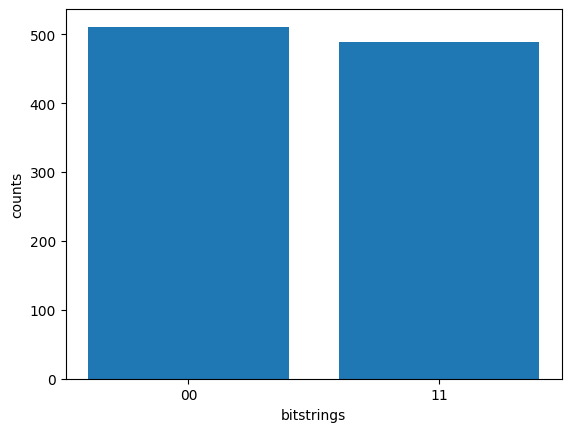

In [8]:
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

### Quantum Hardware: Rigetti

Next we submit our circuit to the superconducting quantum chip provided by Rigetti. Depending on our position in the queue, we may have to wait for some time till our circuit is actually run. However, thanks to asynchronous execution, we can always come back and recover the results by providing the unique ID associated with every quantum task. 

To exectue your quantum task on a device, your task needs to wait for the device to complete running or already queued quantum tasks. Before submitting a quantum task on a device, you can check the queue depth for the quantum tasks. To check the number of hybrid jobs queued on the device call `device.queue_depth().quantum_tasks`. Here, Priority quantum tasks refer to the tasks submitted as part of a Hybrid Job. These quantum tasks has priority over the Normal quantum tasks. 

In [9]:
# check for the queue_depth for quantum tasks on the selected device
rigetti.queue_depth().quantum_tasks

{<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}

In [10]:
# create a clean circuit with no result type attached.(This is because some result types are only supported when shots=0)
bell = Circuit().h(0).cnot(0, 1)  


# run circuit 
rigetti_task = rigetti.run(bell, shots=1000)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
print('ID of task:', rigetti_task_id)
print('Status of quantum task:', rigetti_status)

DeviceOfflineException: An error occurred (DeviceOfflineException) when calling the CreateQuantumTask operation: Device is not available. Status = OFFLINE

In [11]:
# run the circuit and output the results
#task = device.run(bell, shots=0)
#result = task.result()

# print results
#print("Final EXACT state vector:\n", result.values[0])
#print("Expectation value <ZZ>:", np.round(result.values[1], 5))
#print("Amplitude <11|Final state>:", result.values[2])

You can check the position of your quantum task in the queue by calling `task.queue_position().queue_position`. The queue position is only returned when the task is in "QUEUED" state, else None is returned. You can also check why the queue position value is not returned by calling calling `task.queue_position().message`. Here, `task` is the variable to which you assign your quantum_task creation.

In [12]:
# let's check the queue position for task created with the rigetti device
rigetti_task.queue_position().queue_position

NameError: name 'rigetti_task' is not defined

The quantum task is submitted and we can regularly (or irregularly) check the status of this quantum task by executing the following cell. You may easily build logic around this query to wait for this quantum task to complete before your code proceeds. 

In [13]:
# print status
status = rigetti_task.state()
print('Status of (reconstructed) quantum task:', status)

NameError: name 'rigetti_task' is not defined

### Quantum Hardware: IonQ

Next, we submit our example Bell state circuit to IonQ. We set the device as AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony"). This quantum task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this quantum task.

Before submitting our quantum task, let's check the queue depth on the device for quantum tasks.

In [18]:
# 현재 IonQ 디바이스(Forte1) 큐 상태 점검
ionq.queue_depth().quantum_tasks

{<QueueType.NORMAL: 'Normal'>: '5', <QueueType.PRIORITY: 'Priority'>: '1'}

In [15]:
# run circuit
ionq_task = ionq.run(bell, shots=1000)

# get id and status of submitted quantum task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
print('ID of quantum task:', ionq_task_id)
print('Status of quantum task:', ionq_status)

ID of quantum task: arn:aws:braket:us-east-1:122603138466:quantum-task/963dc660-9690-4f3e-82a9-9f2415c01e27
Status of quantum task: QUEUED


Let's check the queue position for the submitted quantum task on the device.

In [16]:
# check the queue position
ionq_task.queue_position().queue_position

'5'

In [17]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) quantum task:', status)

Status of (reconstructed) quantum task: QUEUED


## Quantum Hardware: IQM
Finally, the Bell circuit is submitted to the IQM Garnet device.

task 확인은 스톡홀름 리전에서 가능

In [19]:
# run circuit
iqm_task = iqm.run(bell, shots=1000)

# get id and status of submitted quantum task
iqm_task_id = iqm_task.id
iqm_status = iqm_task.state()
print('ID of quantum task:', iqm_task_id)
print('Status of quantum task:', iqm_status)

ID of quantum task: arn:aws:braket:eu-north-1:122603138466:quantum-task/8c625397-e863-496a-996b-ca824356d1f1
Status of quantum task: QUEUED


In addition to the state of the task, you can monitor the progress by the queue position of the task.

In [20]:
# check the queue position
iqm_task.queue_position().queue_position

'14'

### Parametric compilation
When submitting a parametric circuit to a supported QPU, Braket will compile the circuit once and cached the compiled circuit. For the subsequent parameter updates to the same circuit, there is no recompilation which results in faster runtimes. The cached compiled circuits persist until the end of the availability window of the QPU. To learn more about submitting a parametrized task, see the [Amazon Braket developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-submit-tasks-to-braket.html#braket-submit-parametrized-task).

In [21]:
theta = FreeParameter("theta")
parametrized_circuit = Circuit().rx(0, theta)

angle_value = 0.789 # 라디언 값, 각도로 변환하면 45.22도
#pc_task = rigetti.run(parametrized_circuit, shots=100, inputs={"theta": angle_value})
pc_task = iqm.run(parametrized_circuit, shots=100, inputs={"theta": angle_value})

# get status of submitted quantum task
print('Status of quantum task:', pc_task.state())

Status of quantum task: QUEUED


### Quantum Task Recovery

By simply grabbing the unique quantum task ID associated with the quantum tasks we have submitted above, we can recover this quantum task at any point in time and (once the status is completed) visualize and analyze the corresponding results. Note that apart from other metadata, you can retrieve the compiled circuit that was actually run on the Rigetti device. More information about the compiling process can be found [here](https://pyquil-docs.rigetti.com/en/v2.22.0/compiler.html#partial). 

대부분의 경우, QPU를 이용해서 즉시 결과값을 확인할 수 없다.태스크는 큐에 쌓인다. 따라서 한참 후에 코드가 실행됐을 만큼의 시간이 지난 이후에 작업이 완료되면, 아래 코드를 실행하여 실행 결과를 확인할 수 있다.


In [ ]:
# recover quantum task for Rigetti
#이전에 제출된 양자 작업을 ARN(Amazon Resource Name)을 사용하여 복구
task_load = AwsQuantumTask(arn=rigetti_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) quantum task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results, 양자 작업의 결과를 아래 변수에 저장
    rigetti_results = task_load.result()
  # print(rigetti_results)
    
    # get all metadata of submitted quantum task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.\n".format(shots, machine))
    
    # get the compiled circuit, Quil 언어로 작성된 결과 확인가능, 실제로 컴파일된 양자 회로 출력, 원래 제출한 회로가 Rigetti 하드웨어에 최적화되어 변환된 형태입니다
    print("The compiled circuit is:\n", rigetti_results.additional_metadata.rigettiMetadata.compiledProgram)
    
    # get measurement counts
    rigetti_counts = rigetti_results.measurement_counts
    print('Measurement counts:', rigetti_counts)

    # plot results: see effects of noise
    plt.bar(rigetti_counts.keys(), rigetti_counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('rigetti.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your quantum task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your quantum task is still being processed and has not been finalized yet.')

In [22]:
# recover quantum task for IQM
# 이전에 실행된 양자 작업을 ARN(Amazon Resource Name)을 사용하여 복구
task_load = AwsQuantumTask(arn=iqm_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) quantum task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    iqm_results = task_load.result()
    # print(rigetti_results)
    
    # get all metadata of submitted quantum task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    # 샷의 개수와 어떤 머신을 사용했는지 출력
    print("{} shots taken on machine {}.\n".format(shots, machine))
    
    # get the compiled circuit
    # IQM 양자 컴퓨터에서 실제로 실행된 컴파일된 회로 정보를 출력
    print("The compiled circuit is:\n", iqm_results.additional_metadata.iqmMetadata.compiledProgram)
    
    # get measurement counts
    iqm_counts = iqm_results.measurement_counts
    print('Measurement counts:', iqm_counts)

    # plot results: see effects of noise
    plt.bar(iqm_counts.keys(), iqm_counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('iqm.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your quantum task is in terminal status, but has not completed.')

# 태스크가 아직도 처리가 되지 않았다면
else:
    # print current status
    print('Sorry, your quantum task is still being processed and has not been finalized yet.')

Status of (reconstructed) quantum task: QUEUED


Sorry, your quantum task is still being processed and has not been finalized yet.


In [23]:
# recover quantum task for ionq
task_load = AwsQuantumTask(arn=ionq_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) quantum task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    # print(rigetti_results)
    
    # get all metadata of submitted quantum task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('bell_ionq.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your quantum task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your quantum task is still being processed and has not been finalized yet.')

Status of (reconstructed) quantum task: QUEUED
Sorry, your quantum task is still being processed and has not been finalized yet.


We have successfully recovered the results associated with the quantum tasks that were queued up for the quantum hardware providers. Because of noise (decoherence) and other imperfections we cannot fully recover the exact results we have seen when using the classical simulator. To deal with that, in the fullness of time we will be able to use error correction techniques. As long as error correction is not available, it is important to benchmark our quantum results using classical simulators, whenever possible. 

---
# APPENDIX

굳이 할 필요 없음

In [ ]:
# set up device
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2")

# run circuit
task = rigetti.run(bell, shots=1000)
print('Information on quantum task:\n', task)
print('==================================' * 2)

# get status of submitted quantum task
status = task.state()

# wait for job to complete
terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
# 잡이 대기상태면 현재 상태를 계속 출력
while status not in terminal_states:
    status = task.state()
    print('Status:', status)
    # time.sleep(60)
    
# 처리가 완료되면(completed)
print('Status:', status)

# get results
rigetti_results = task.result()
print(rigetti_results)

print(" ")
print(" ")
# get measurement counts
rigetti_counts = rigetti_results.measurement_counts
print(rigetti_counts)

# plot results: see effects of noise
plt.bar(rigetti_counts.keys(), rigetti_counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.tight_layout()
plt.savefig('rigetti2.png', dpi=700)

In [ ]:
# set up device
iqm = AwsDevice(Devices.IQM.Garnet)

# run circuit
task = iqm.run(bell, shots=1000)
print('Information on quantum task:\n', task)
print('==================================' * 2)

# get status of submitted quantum task
status = task.state()

# wait for job to complete
terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
while status not in terminal_states:
    status = task.state()
    print('Status:', status)
    # time.sleep(60)

#print('Status:', status)

# get results
iqm_results = task.result()
print(iqm_results)

# get measurement counts
iqm_counts = iqm_results.measurement_counts
print(iqm_counts)

# plot results: see effects of noise
plt.bar(iqm_counts.keys(), iqm_counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.tight_layout()
plt.savefig('iqm.png', dpi=700)

In [ ]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")